In [1]:
%load_ext autoreload
%autoreload 2


### Necessary Imports
Following notebook uses python chess package and core functionality from custom SARFA package such as computing SARFA metric, visualization of board, etc.

In [2]:
import chess
from sarfa import core, OffenseDefenseBoardVisualization, SarfaBaseline, Engine, RemovalPerturber
from sarfa.utils import get_all_pos, read_fens
from IPython.display import Image, display
from collections import defaultdict

### Offensive vs. Defensive Saliency
By our new definition of offensive vs. defensive saliency, the original SARFA paper only focused on offensive saliency. Our key innovation here is to also consider perturbations (removing individual pieces) that increase the likelihood of the agent making that move. In the original SARFA, one of the metrics returned is $dP$, where $dP$ is simply $Q(s, a) - Q(s', a)$. This means after removing a piece ($s'$), the algorithm was looking for $dP > 0$ because that would suggest that the removed piece is crucial to the move being made. This new method also considers when $dP < 0$. In other words, what pieces are preventing an action from being taken (i.e. defensive saliency).

The following function uses a RemovalPerturber class that acts as a generator for perturbed board states and then uses the dP result from the SARFA metric to differentiate between offense and defense. The output is a dictionary containing the saliency results and the action being considered.

In [3]:
def offense_defense_saliency_algorithm(fen, action=None) -> tuple[dict[str, tuple[str, float]], chess.Move]:
    board = chess.Board(fen)

    saliency_results: dict[str, tuple[str, float]] = defaultdict(int)
    perturber = RemovalPerturber(board)
    saliency_calculator = SarfaBaseline(engine, board)
    optimal_move_original_board = action

    for perturbed_board, perturbed_position_str in perturber.process():
        sarfa_compute_result = saliency_calculator.compute(perturbed_board, 
        action, allow_defense=True)
        saliency = sarfa_compute_result.saliency
        dP = sarfa_compute_result.dP
        optimal_move = sarfa_compute_result.optimal_move


        if (optimal_move_original_board == None):
            optimal_move_original_board = chess.Move.from_uci(optimal_move)

        saliency_type = ""
        if dP < 0:
            saliency_type = "defensive"
            saliency = abs(saliency)
        else:
            saliency_type = "offensive"

        saliency_results[perturbed_position_str] = [saliency_type, saliency]

    return saliency_results, optimal_move_original_board


### Testing on Relevant Boards
FENs are a compact string representation of chess boards. The following section allows for testing of the offense/defense saliency method on a variety of relevant FENs. These FENs are stored in .txt files under the test_fens/ folder. The user can change the index of the FEN (up to the number of FENs in the file) to run the evaulation on a different board. 

The code also initializes an Engine class that is a wrapper around the chess.engine functionality provided by the python-chess library. In this case, we are using an executable file for Stockfish, which is a commonly used computer engine in the chess community.

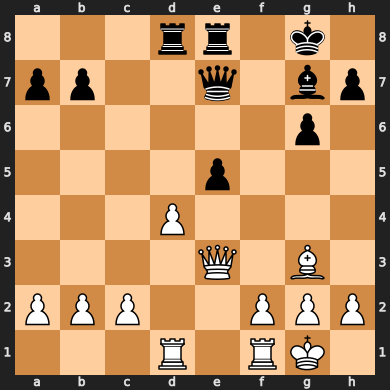

In [4]:
idx = 2
fens = read_fens('./test_fens/off_def_fens.txt')
FEN = fens[idx]
board = chess.Board(FEN)

engine = Engine("./stockfish_15_x64_avx2")
board_visualization = OffenseDefenseBoardVisualization(board)
board_visualization.only_board()

### Choosing an action
For most methods, using the optimal action as suggested by the engine is enough to test the accuracy of the approach. However, one of the main features of the offense/defense approach is to be able to query a specific action and understand why the agent might NOT have taken that action. Therefore, defining the action be analyzed is critical for generating the saliency results.

In [5]:
action = chess.Move.from_uci('e5d4')
saliency_results, optimal_move_original_board = offense_defense_saliency_algorithm(FEN, action=action)

# List saliency results dictionary of form {<board square>: [<offense/defense classification>, <saliency>]}
saliency_results

defaultdict(int,
            {'a2': ['defensive', 0.017190448572097727],
             'a7': ['defensive', 0.03948984771470807],
             'b2': ['offensive', 0.008782437603021526],
             'b7': ['defensive', 0.011813954396489799],
             'c2': ['offensive', 0.011338382405570412],
             'd1': ['defensive', 0.07207557306632122],
             'd4': ['offensive', 1],
             'd8': ['defensive', 0.7777626925741566],
             'e3': ['defensive', 0.1316007653796028],
             'e5': ['offensive', 1],
             'e7': ['defensive', 0.7115851679221418],
             'e8': ['offensive', 0.019459637350724715],
             'f1': ['defensive', 0.07939028660483088],
             'f2': ['offensive', 0.015739167576439898],
             'g2': ['offensive', 0.016076029705604667],
             'g3': ['defensive', 1.1334016838472],
             'g6': ['defensive', 0.037203014426036525],
             'g7': ['defensive', 0.16869541529670312],
             'h2': ['offensi

### Explanation of Results
The following cell shows a heatmap visualization of the offensive/defensive saliency for the highlighted move (exd4). Based on the saliency_results dictionary, the visualization uses a cutoff to color specific pieces blue for defensive or red for offensive. Here, both pawns in the center are offensive because they are necessary for the offensive action to take place. However, the white bishop is effectively playing defense because the black queen and rook are placed in spots that allow for a crucial pin. If the black pawn captures the white pawn, the white queen can trade off the queens and then the two rooks would be lined up for a bishop pin. Therefore, the method is able to capture the defensive saliency of the white bishop over longer horizons.

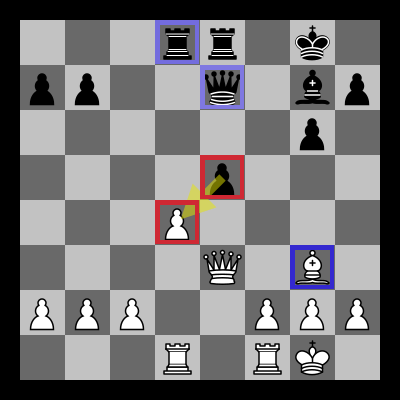

In [6]:
path = board_visualization.show_heatmap(saliency_results, optimal_move_original_board)
display(Image(path))